# *Lending Club Loan Default*

In this tutorial, we will go through a step-by-step workflow to determine loan deliquency. Predictions will be made based only on the information available at the time the loan was issued.  Our data is a portion of the public Lending Club data set.

## Workflow

1. Start H2O-3 cluster
2. Import data
3. Clean data
4. Feature engineering
5. Model training
6. Examine model accuracy
7. Interpret model
8. Save and reuse model
9. AutoML (optional)
10. Stop H2O-3 cluster

# Step 1 (of 10). Start H2O-3 cluster

The method you use for starting and stopping an H2O-3 cluster will depend on how H2O is set up on your system. The method we show here is the simplest and most straightforward. It is critical, however, that you properly shut down any H2O cluster that you start.

In [1]:
import h2o
h2o.init(bind_to_localhost=False)  # run and expose the cluster to the Internet

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,3 hours 59 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_unknownUser_dtjiun
H2O cluster total nodes:,1
H2O cluster free memory:,11.97 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"locked, healthy"


# Step 2 (of 10). Import data

A full description of the complete Lending Club data is available at kaggle.com [here](https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data/notebook). 

The data set we use below is a local copy of https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/lending/lending_club/LoanStats3a.csv.

### View and Inspect the Data

The loans data is loaded directly into H2O using the following command:

In [2]:
loans = h2o.import_file("../../data/lending_club/LoanStats3a.csv",
                        col_types = {"int_rate":"string", 
                                     "revol_util":"string", 
                                     "emp_length":"string", 
                                     "verification_status":"string"})

Parse progress: |█████████████████████████████████████████████████████████| 100%


Note that the `h2o.import_file` command completely bypassed python and loaded the data directly into H2O memory. Alternatively, one could load a dataset into a python object, for instance, then pass it to H2O. The approach we use above is far more efficient and generally recommended, especially as data size increases.

### Inspect the Data with H2O Flow

Now is a good time to enable H2O Flow. Although H2O Flow can be used for everything from loading data to building models to creating production code, we use it here for data investigation and H2O system monitoring.

> Note: the reported IP above 
>
>```
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
>```
>
> is the local IP within your particular cloud instance. 
>
> **To open H2O Flow in your own browser, copy your browser URL and replace the port with 54321.**
>
>> For example, my Jupyter notebook's URL is 
>>
>>`http://52.202.98.125:8888`. 
>>
>> After opening a new browser tab or window, I copy the address and replace port `8888` with `54321`:
>>
>>`http://52.202.98.125:54321`.

A quick summary of the data size and data fields are shown below.

In [3]:
loans.dim

[42536, 52]

In [4]:
loans.head()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
1.0775e+06,1.2966e+06,5000,5000,4975,36 months,10.65%,162.87,B,B2,,10+ years,RENT,24000,VERIFIED - income,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.,credit_card,Computer,860xx,AZ,27.65,0,1985-01-01 00:00:00,1,,,3,0,13648,83.7%,9,f,0,0,5861.07,5831.78,5000,861.07,0,0,0,2015-01-01 00:00:00,171.62,,2015-01-01 00:00:00,0,,1
1.07743e+06,1.31417e+06,2500,2500,2500,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000,VERIFIED - income source,2011-12-01 00:00:00,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up. Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces,car,bike,309xx,GA,1,0,1999-04-01 00:00:00,5,,,3,0,1687,9.4%,4,f,0,0,1008.71,1008.71,456.46,435.17,0,117.08,1.11,2013-04-01 00:00:00,119.66,,2013-09-01 00:00:00,0,,1
1.07718e+06,1.31352e+06,2400,2400,2400,36 months,15.96%,84.33,C,C5,,10+ years,RENT,12252,not verified,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,,small_business,real estate business,606xx,IL,8.72,0,2001-11-01 00:00:00,2,,,2,0,2956,98.5%,10,f,0,0,3003.65,3003.65,2400,603.65,0,0,0,2014-06-01 00:00:00,649.91,,2015-06-01 00:00:00,0,,1
1.07686e+06,1.27718e+06,10000,10000,10000,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200,VERIFIED - income source,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.",other,personel,917xx,CA,20,0,1996-02-01 00:00:00,1,35,,10,0,5598,21%,37,f,0,0,12226.3,12226.3,10000,2209.33,16.97,0,0,2015-01-01 00:00:00,357.48,,2015-01-01 00:00:00,0,,1
1.07536e+06,1.31175e+06,3000,3000,3000,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000,VERIFIED - income source,2011-12-01 00:00:00,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and freeing up some extra each month to pay toward other bills. I've always been a good payor but have found myself needing to make adjustments to my budget due to a medical scare. My job is very stable, I love it.",other,Personal,972xx,OR,17.94,0,1996-01-01 00:00:00,0,38,,15,0,27783,53.9%,38,f,1168.04,1168.04,2767.64,2767.64,1831.96,935.68,0,0,0,2015-06-01 00:00:00,67.79,2015-07-01 00:00:00,2015-06-01 00:00:00,0,,1
1.07527e+06,1.31144e+06,5000,5000,5000,36 months,7.90%,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000,VERIFIED - income source,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanD

------

>## Editorial comment: Data preparation for modeling
>
>In this tutorial, we either omit or rush through some steps that a modeler normally would spend a considerable amount of time on. For example, we completely skip exploratory data analysis used in conjunction with modeling. Additionally, the process of **_defining the problem_** is often iterative and takes a lot of thought and effort. We make the assumption here that this work has already been done by the modeler.
>
>In reality, the majority of a modeler's time is spent on problem definition and data cleaning/wrangling/munging. Our speed at going through these steps to demonstrate the use of H2O-3 in no way minimizes the importance of careful and thoughtful data preparation for model building. 

-----


# Step 3 (of 10).  Clean data


## Part 1. Defining the problem and creating the response variable

The total number of loans in our data is

In [5]:
num_unfiltered_loans = loans.dim[0]
num_unfiltered_loans

42536

Because we are interested in loan default, we need to look at the `loan_status` column.

In [6]:
loans["loan_status"].table().head(20)

loan_status,Count
Charged Off,5435
Current,3351
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Current,53
Does not meet the credit policy. Status:Fully Paid,1933
Does not meet the credit policy. Status:In Grace Period,2
Fully Paid,30843
In Grace Period,60
Late (16-30 days),16


Like many real data sources, `loan_status` is messy and contains multiple (somewhat overlapping) categories. Before modeling, we will need to clean this up by (1) removing loans that are still ongoing, and (2) simplifying the response column.

### (1) Filter Loans

In order to build a valid model, we have to remove loans that are not yet completely "good" or "bad". These ongoing loans have `loan_status` like "Current" and "In Grace Period".

In [7]:
ongoing_status = ["Current",
                  "In Grace Period",
                  "Late (16-30 days)",
                  "Late (31-120 days)",
                  "Does not meet the credit policy.  Status:Current",
                  "Does not meet the credit policy.  Status:In Grace Period"
                 ]
loans = loans[~loans["loan_status"].isin(ongoing_status)]

After filtering out ongoing loans, we now have

In [8]:
num_filtered_loans = loans.dim[0]
num_filtered_loans

38980

loans whose final state is known, which means we filtered out

In [9]:
num_loans_filtered_out = num_unfiltered_loans - num_filtered_loans
num_loans_filtered_out

3556

loans. 

These loans are now summarized by `loan_status` as

In [10]:
loans["loan_status"].table().head(20)

loan_status,Count
Charged Off,5435
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Fully Paid,1933
Fully Paid,30843


### (2) Create Response Column

Let's name our response column `bad_loan`, which will be equal to one if the loan was not completely paid off.

In [11]:
fully_paid = ["Fully Paid",
              "Does not meet the credit policy.  Status:Fully Paid"
             ]
loans["bad_loan"] = ~(loans["loan_status"].isin(fully_paid))

Make the `bad_loan` column a factor so we can build a classification model,

In [12]:
loans["bad_loan"] = loans["bad_loan"].asfactor()

The percentage of bad loans is given by

In [13]:
bad_loan_dist = loans["bad_loan"].table()
bad_loan_dist["Percentage"] = (100 * bad_loan_dist["Count"] / loans.nrow).round()
bad_loan_dist

bad_loan,Count,Percentage
0,32776,84
1,6204,16


## Part 2. Convert strings to numeric

Consider the data columns `int_rate`, `revol_util`, and `emp_length`:

In [14]:
loans[["int_rate", "revol_util", "emp_length"]].head()

int_rate,revol_util,emp_length
10.65%,83.7%,10+ years
15.27%,9.4%,< 1 year
15.96%,98.5%,10+ years
13.49%,21%,10+ years
7.90%,28.3%,3 years
18.64%,87.5%,9 years
21.28%,32.6%,4 years
12.69%,36.5%,< 1 year
14.65%,20.6%,5 years
12.69%,67.1%,10+ years


Both `int_rate` and `revol_util` are inherently numeric but entered as percentages. Since they include a "%" sign, they are read in as strings. The solution for both of these columns is simple: strip the "%" sign and convert the strings to numeric.

The `emp_length` column is only slightly more complex. Besides removing the "year" or "years" word, we have to deal with `< 1` and `10+`, which aren't directly numeric. If we define `< 1` as 0 and `10+` as 10, then `emp_length` can also be cast as numeric.

We demonstrate the steps for converting these string variables into numeric values below.

### Convert `int_rate`

In [15]:
loans["int_rate"] = loans["int_rate"].gsub(pattern = "%", replacement = "") # strip %
loans["int_rate"] = loans["int_rate"].trim() # trim whitespace
loans["int_rate"] = loans["int_rate"].asnumeric() # change to numeric 

### Convert `revol_util`

In [16]:
loans["revol_util"] = loans["revol_util"].gsub(pattern="%", replacement="") # strip %
loans["revol_util"] = loans["revol_util"].trim() # trim whitespace
loans["revol_util"] = loans["revol_util"].asnumeric() # change to numeric 

### Convert `emp_length`

In [17]:
# Use gsub to remove " year" and " years"; also translate n/a to "" 
loans["emp_length"] = loans["emp_length"].gsub(pattern="([ ]*+[a-zA-Z].*)|(n/a)", replacement="") 
loans["emp_length"] = loans["emp_length"].trim() # trim whitespace

loans["emp_length"] = loans["emp_length"].gsub(pattern="< 1", replacement="0") # convert "< 1" to 0
loans["emp_length"] = loans["emp_length"].gsub(pattern="10\\+", replacement="10") # convert "10+" to 10
loans["emp_length"] = loans["emp_length"].asnumeric() # trim whitespace

The converted results for the three former string variables are

In [18]:
loans[["int_rate", "revol_util", "emp_length"]].head()

int_rate,revol_util,emp_length
10.65,83.7,10
15.27,9.4,0
15.96,98.5,10
13.49,21,10
7.9,28.3,3
18.64,87.5,9
21.28,32.6,4
12.69,36.5,0
14.65,20.6,5
12.69,67.1,10


### Note: Interest rate distributions

Now that we have converted interest rate to numeric, we can use the `hist` function to compare the interest rate distributions for good and bad loans.

Bad Loans


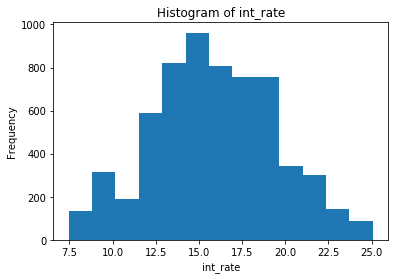

Good Loans


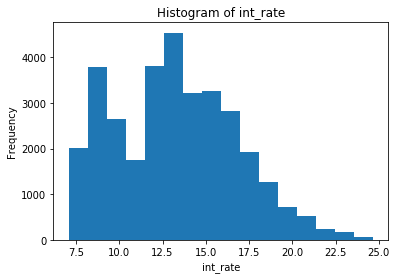

In [19]:
%matplotlib inline

print("Bad Loans")
loans[loans["bad_loan"] == "1", "int_rate"].hist()

print("Good Loans")
loans[loans["bad_loan"] == "0", "int_rate"].hist()

As expected, the bad loan distribution contains a higher proportion of high interest rates than the distribution for good loans. Likewise, the good loan distribution contains a higher proportion of low interest rates than that for bad loans. It is a truism to say that interest rate should be a good predictor of default.

>Financial institutions typically determine a loan's interest rate based largely on risk and customer demand. If the underwriting rules are any good at all, then we would expect that interest rate would be a strong predictor of default. In fact, we should be surprised if `int_rate` is not one of the top two or three variables in our model regardless of algorithm.

## Part 3. Clean up messy categorical columns

Much as we did with the `loan_status` column to create our response variable, the `verification_status` column needs cleaning

In [20]:
loans["verification_status"].head()

verification_status
VERIFIED - income
VERIFIED - income source
not verified
VERIFIED - income source
VERIFIED - income source
VERIFIED - income source
VERIFIED - income source
VERIFIED - income
not verified
VERIFIED - income source


Note that there are multiple values that mean verified: `VERIFIED - income` and `VERIFIED - income source`.  We will replace these values with `verified`,

In [21]:
loans["verification_status"] = loans["verification_status"].sub(pattern="VERIFIED - income source", 
                                                                replacement="verified")
loans["verification_status"] = loans["verification_status"].sub(pattern="VERIFIED - income", 
                                                                replacement="verified")
loans["verification_status"] = loans["verification_status"].asfactor()

resulting in

In [22]:
loans["verification_status"].table()

verification_status,Count
not verified,17947
verified,21032


# Step 4 (of 10).  Feature engineering

Now that we have cleaned our data, we can extract information from our current columns to create new features. This process is referred to as _feature engineering_. The general idea is to express information found in our data in a manner that is most understandable to the algorithms we employ, with the goal of improving the performance of our supervised learning models.

Feature engineering can be considered the "secret sauce" in building a superior predictive model: it is often (although not always) more important than the choice of machine learning algorithm. A very good summary of feature engineering recipes can be found in the online [Driverless AI Documentation](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/transformations.html). 

We will do some basic feature engineering using the date fields in our data, and then use NLP (natural language processing) to create word embedding features from the loan description text field in our data.

The new columns we will create are: 
* `credit_length`: the number of years someone has had a credit history
* `issue_d_year` and `issue_d_month`: the year and month from the loan issue date
* word embeddings from the loan description

### Credit Length

We can extract the credit length by subtracting the year of their earliest credit line from the year they were issued the loan.

In [23]:
loans["credit_length"] = loans["issue_d"].year() - loans["earliest_cr_line"].year()
loans["credit_length"].head()

credit_length
26
12
10
15
7
4
7
7
13
22


### Issue Date Expansion

We next extract the year and month from the issue date.  We may find that the month or the year when the loan was issued will impact the probability of a bad loan. We will treat `issue_d_month` as a factor, since months are cyclical.

In [24]:
loans["issue_d_year"] = loans["issue_d"].year()
loans["issue_d_month"] = loans["issue_d"].month().asfactor()

loans[["issue_d_year", "issue_d_month"]].head()

issue_d_year,issue_d_month
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12


### Word Embeddings

One of the columns in our dataset is a user-provided description of why the loan was requested. The first few descriptions in the dataset are shown below.

In [25]:
loans["desc"].head()

desc
Borrower added on 12/22/11 > I need to upgrade my business technologies.
Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up. Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces
""
"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time."
""
Borrower added on 12/16/11 > Downpayment for a car.
Borrower added on 12/21/11 > I own a small home-based judgment collection business. I have 5 years experience collecting debts. I am now going from a home office to a small office. I also plan to buy a small debt portfolio (eg. $10K for $1M of debt) My score is not A+ because I own my home and have no mortgage.
"Borrower added on 12/16/11 > I'm trying to build up my credit history. I live with my brother and have no car payment or credit cards. I am in community college and work full time. Im going to use the money to make some repairs around the house and get some maintenance done on my car. Borrower added on 12/20/11 > $1000 down only $4375 to go. Thanks to everyone that invested so far, looking forward to surprising my brother with the fixes around the house."
"Borrower added on 12/15/11 > I had recived a loan from Citi Financial about a year ago, I was paying 29.99 intrest, so the refinance is to cut that rate since cleaning up my credit I have been paying everything on time as shown on my credit report"
""


The descriptions above may contain information that would assist in predicting default, but supervised learning algorithms in general have a hard time understanding text. We need to convert these strings into a numeric representation of the text in order for our algorithms to utilize it. There are multiple choices for doing so, in this example we will use the Word2Vec algorithm.

We start by defining stop words (terms that are considered too frequent to carry much information) 

In [26]:
STOP_WORDS = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what",
              "there","all","we","one","the","a","an","of","or","in","for","by","on",
              "but","is","in","a","not","with","as","was","if","they","are","this","and","it","have",
              "from","at","my","be","by","not","that","to","from","com","org","like","likes","so"]

We next _tokenize_ the descriptions by breaking the text into individual words

In [27]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

words = tokenize(loans["desc"].ascharacter())

We next train our Word2Vec model on the words extracted from our descriptions. We choose an output vector size of 100.

>What does Word2Vec do? At a high level, it is a dimensionality reduction method for numerical representations of text. But it reduces dimensionality while preserving (and discovering?) relationships between words in the text.
>
>Suppose we were to create a dictionary of all the words in our descriptions, and suppose that dictionary contained 2500 unique words. At one extreme, we could create an indicator variable for each word (i.e., one-hot encoding). This would yield 2500 new features that would likely lead to massive overfitting of models.
>
>At the other extreme, suppose we had someone classify those words into different groups and create indicator variables for each: e.g., `risky_words` ("bankruptcy", "default", "forfeit", "lien", etc.), `angry_words` (profanity, "complaint", etc.), and so on. This reduces dimensionality by manually grouping words, but it is extremely labor intensive.
>
>Word2Vec starts with the entire dictionary size $K$ as inputs and the selected vector size $k$ as the target number of outputs. In the in-between layer(s) of the Word2Vec neural net, a $k$-dimensional numeric representation of each word is derived. 

In [28]:
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(vec_size=100, model_id="w2v")
w2v_model.train(training_frame=words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


Sanity check the Word2Vec model by finding synonyms for the word "car"

In [29]:
w2v_model.find_synonyms("car", count=5)

OrderedDict([('auto', 0.7251068949699402),
             ('vehicle', 0.7225008010864258),
             ('lexus', 0.68996661901474),
             ('prius', 0.6546204090118408),
             ('basics', 0.6523770093917847)])

Next calculate a vector for each description by averaging over all of the words in that description

In [30]:
desc_vecs = w2v_model.transform(words, aggregate_method="AVERAGE")
desc_vecs.head()

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.160525,0.00761051,-0.0377313,0.0285343,0.0154623,0.158197,-0.0184205,-0.00960125,0.139328,0.024116,0.0448829,0.0988865,-0.0261553,0.119325,-0.0121504,-0.0412286,-0.0293693,0.0633247,-0.116739,0.131319,-0.0482528,-0.0504041,-0.107736,-0.215233,0.100815,-0.138292,0.00889922,-0.0496393,0.0789243,0.147803,0.0106898,0.0343641,-0.0558935,0.204854,0.218231,0.0506003,-0.291379,-0.0847885,0.139746,0.0955225,0.132744,0.13223,-0.0250325,0.122236,-0.0349447,0.0584957,-0.235584,0.231621,-0.0739045,-0.0628561,-0.18381,0.113739,0.129687,0.00439531,-0.127242,-0.101909,-0.0336422,-0.0470027,0.105895,-0.22577,-0.1518,0.0361075,0.136196,-0.0960417,0.024433,-0.00190374,0.00296207,-0.171784,0.152318,-0.146594,0.0319771,-0.178962,0.318153,-0.0414293,0.044025,-0.0454132,-0.00187672,0.0263587,-0.180081,-0.0647765,-0.00292424,-0.00289404,-0.236992,0.208602,-0.119156,-0.0948885,0.108986,0.215363,-0.0548204,0.0616262,-0.00531904,0.201846,-0.169849,0.0989916,0.0814215,-0.36751,-0.0249119,-0.212598,-0.00868209,0.041939
0.0946685,-0.0600831,-0.0754993,0.0192999,-0.121621,0.0965942,0.00718257,0.0187955,0.0604868,0.170454,0.0431232,0.228759,0.0307808,0.22245,-0.103675,0.0705864,-0.00133187,0.148238,-0.181311,0.0658273,-0.0209716,-0.0769212,-0.182288,0.0685154,-0.03795,-0.165008,-0.124268,-0.016029,-0.08626,0.320871,-0.0595745,0.0841508,-0.0289617,0.0754162,0.0952343,0.235495,-0.0274061,-0.0755774,0.0847501,0.0897273,0.0723533,0.063794,-0.0945986,0.118945,-0.11366,0.0393999,-0.110674,0.0947004,-0.0159532,-0.0910717,-0.0822164,0.0472332,0.101807,0.0230666,-0.0789731,-0.0629389,-0.120535,-0.00550684,-0.0148922,-0.12935,-0.0622137,-0.056351,0.0906715,-0.0627987,0.00271866,0.0297373,-0.0741178,-0.0267454,0.109704,0.0331209,0.0848631,-0.188856,0.146278,-0.046894,0.0911453,0.0168659,-0.13544,0.114928,-0.179049,-0.170135,0.0360242,0.00945544,-0.140764,0.154345,0.036895,0.0226151,0.18463,0.205897,0.00989798,0.141551,-0.0453451,0.132386,-0.1177,-0.0370013,0.0803143,-0.302337,0.0200383,-0.171648,-0.04265,0.011786
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.0427071,-0.0489399,-0.139117,-0.0191604,-0.0361171,0.216148,0.0442603,0.199087,0.0771905,0.132153,-0.0313347,0.238872,-0.00539962,0.199942,-0.0520675,0.00422052,-0.00450643,0.128995,-0.126036,0.0838985,0.00423935,-0.0675533,-0.133831,0.0399523,0.0824972,-0.142285,-0.122337,-0.0109865,-0.0206447,0.246179,-0.0873067,0.0840225,-0.0868387,0.127659,0.112585,0.151928,-0.0322136,-0.0739292,0.128772,0.0865003,0.172322,-0.0336826,-0.00559888,0.137536,-0.0759385,0.0297574,-0.0407981,0.0773642,-0.0071748,0.0311618,-0.165983,0.026619,0.0817571,0.0749275,-0.150863,-0.114863,-0.0462189,0.0285289,0.0457149,-0.0467766,-0.0998676,0.12895,0.0993069,-0.00443761,-0.0356711,0.052551,-0.0463792,0.0331418,0.0910198,0.023352,0.0710756,-0.242376,0.111388,0.0060259,-0.0142879,-0.0220916,-0.165299,0.00504482,-0.143959,-0.145436,-0.0147034,-0.0211052,-0.173795,0.155726,0.0875811,-0.00701321,0.182273,0.168978,-0.0116081,0.141663,-0.120007,0.164056,-0.11311,0.0155107,0.0560935,-0.339076,0.0156379,-0.215856,0.0767632,0.0371534
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

Add the aggregated word embeddings from the Word2Vec model to the loans data

In [31]:
loans = loans.cbind(desc_vecs)

# Step 5 (of 10). Model training

Now that we have cleaned our data and added new columns, we will train a model to predict bad loans. First split our data into train and test.

In [32]:
train, test = loans.split_frame(seed=25, ratios=[0.75])

In [33]:
cols_to_remove = ["initial_list_status",
                  "out_prncp",
                  "out_prncp_inv",
                  "total_pymnt",
                  "total_pymnt_inv",
                  "total_rec_prncp", 
                  "total_rec_int",
                  "total_rec_late_fee",
                  "recoveries",
                  "collection_recovery_fee",
                  "last_pymnt_d", 
                  "last_pymnt_amnt",
                  "next_pymnt_d",
                  "last_credit_pull_d",
                  "collections_12_mths_ex_med" , 
                  "mths_since_last_major_derog",
                  "policy_code",
                  "loan_status",
                  "funded_amnt",
                  "funded_amnt_inv",
                  "mths_since_last_delinq",
                  "mths_since_last_record",
                  "id",
                  "member_id",
                  "desc",
                  "zip_code"]

predictors = list(set(loans.col_names) - set(cols_to_remove))

Next create a list of predictors as a subset of the columns of the `loans` H2O Frame

In [34]:
predictors

['C31',
 'C36',
 'emp_length',
 'C80',
 'C78',
 'inq_last_6mths',
 'pymnt_plan',
 'C53',
 'C17',
 'C4',
 'C72',
 'C79',
 'C54',
 'bad_loan',
 'dti',
 'C56',
 'C24',
 'C41',
 'sub_grade',
 'C55',
 'C9',
 'C60',
 'earliest_cr_line',
 'C69',
 'C3',
 'C75',
 'C16',
 'C51',
 'C64',
 'credit_length',
 'C57',
 'C27',
 'revol_bal',
 'C49',
 'C99',
 'addr_state',
 'C11',
 'C28',
 'url',
 'C35',
 'C76',
 'C48',
 'C87',
 'C73',
 'C1',
 'C88',
 'C33',
 'issue_d',
 'C58',
 'C47',
 'term',
 'C95',
 'C45',
 'revol_util',
 'C32',
 'C19',
 'purpose',
 'issue_d_year',
 'C20',
 'C42',
 'C23',
 'C90',
 'C18',
 'C71',
 'emp_title',
 'C30',
 'C2',
 'C40',
 'C6',
 'C29',
 'C59',
 'C93',
 'C8',
 'C92',
 'C34',
 'installment',
 'C46',
 'C7',
 'issue_d_month',
 'C22',
 'C52',
 'C25',
 'C100',
 'C84',
 'delinq_2yrs',
 'C91',
 'C12',
 'C65',
 'C61',
 'C37',
 'C81',
 'C77',
 'C70',
 'C74',
 'annual_inc',
 'verification_status',
 'C39',
 'C66',
 'C85',
 'C44',
 'C50',
 'C15',
 'C14',
 'C13',
 'home_ownership',
 'lo

Now create an XGBoost model for predicting loan default. This model is being run with almost all of the values at their defaults. Later we may want to optimize the hyperparameters using a grid search. 

In [35]:
from h2o.estimators import H2OXGBoostEstimator

param = {
      "ntrees" : 20
    , "nfolds" : 5
    , "seed": 25
}
xgboost_model = H2OXGBoostEstimator(**param)
xgboost_model.train(x = predictors,
                    y = "bad_loan",
                    training_frame=train,
                    validation_frame=test)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


# Step 6 (of 10).  Examine model accuracy

The plot below shows the performance of the model as more trees are built.  This graph can help us see at what point our model begins overfitting.  Our test data error rate stops improving at around 8-10 trees.

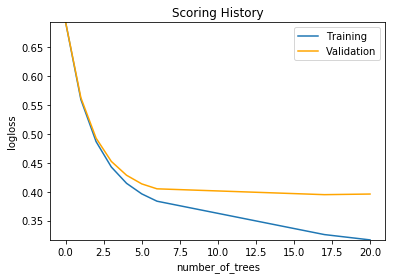

In [36]:
%matplotlib inline
xgboost_model.plot()

The ROC curve of the training and testing data are shown below.  The area under the ROC curve is much higher for the training data than the test data, indicating that the model may be beginning to memorize the training data.

Training Data


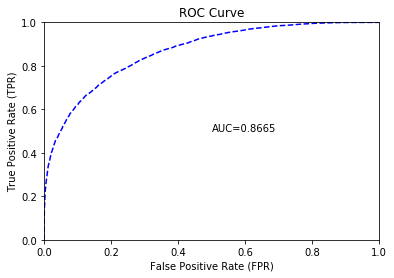

Testing Data


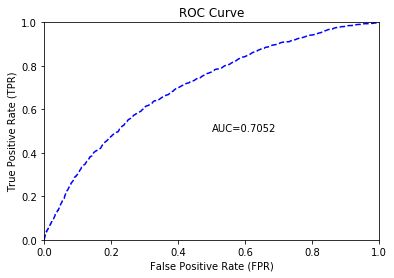

X-Val


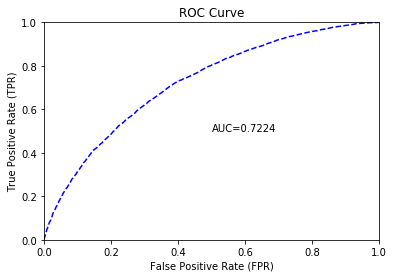

In [37]:
print("Training Data")
xgboost_model.model_performance(train = True).plot()
print("Testing Data")
xgboost_model.model_performance(valid = True).plot()
print("X-Val")
xgboost_model.model_performance(xval=True).plot()

# Step 7 (of 10). Interpret model

The variable importance plot shows us which variables are most important to predicting `bad_loan`.  We can use partial dependency plots to learn more about how these variables affect the prediction.

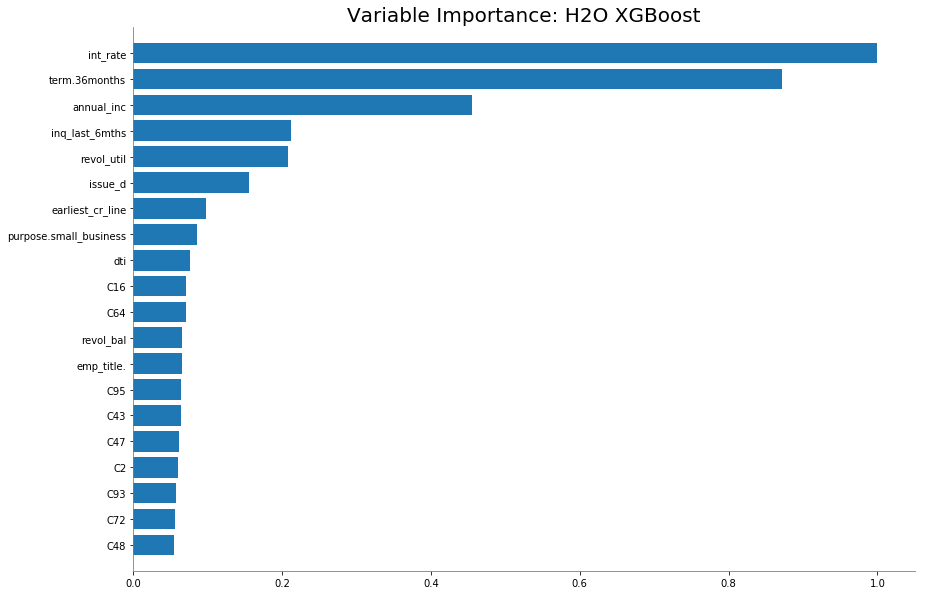

In [38]:
xgboost_model.varimp_plot(20)

As suspected, interest rate appears to be the most important feature in predicting loan default. The partial dependency plot of the `int_rate` predictor shows us that as the interest rate increases, the likelihood of the loan defaulting also increases.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


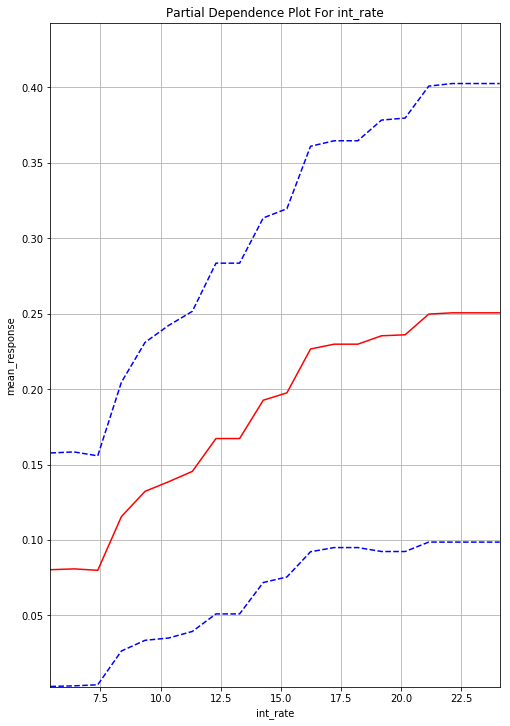

In [39]:
pdp = xgboost_model.partial_plot(cols=["int_rate"], data=train)

# Step 8 (of 10). Save and reuse model

The model can either be embedded into a self-contained Java MOJO package
or it can be saved and later loaded directly into an H2O-3 cluster. For production
use, we recommend using MOJO as it is optimized for speed. See the [guide](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html) for further information.

### Downloading MOJO

In [40]:
xgboost_model.download_mojo()

'/home/h2o/h2o-3_hands_on/lending_club_loan_default/XGBoost_model_python_1562812581040_6274.zip'

### Save and reuse the model 

We can save the model to disk for later use.

In [41]:
model_path = h2o.save_model(model=xgboost_model, force=True)
print(model_path)

/home/h2o/h2o-3_hands_on/lending_club_loan_default/XGBoost_model_python_1562812581040_6274


At a later date, we can load the model for batch scoring in the H2O cluster.

In [42]:
loaded_model = h2o.load_model(path=model_path)

We can also score new data using the predict function:

In [43]:
bad_loan_hat = loaded_model.predict(test)
bad_loan_hat.head(15)

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
1,0.757506,0.242494
0,0.98109,0.0189097
1,0.727931,0.272069
1,0.808524,0.191476
0,0.922618,0.0773818
0,0.959198,0.0408023
0,0.954456,0.045544
0,0.936335,0.0636654
0,0.966383,0.0336167
1,0.763358,0.236642


# Step 9 (of 10). AutoML (optional)

AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit or user specified model build limit. 

Stacked Ensembles will be automatically trained on collections of individual models to produce highly predictive ensemble models.

In [44]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models=5, 
                max_runtime_secs_per_model=60, 
                include_algos = ["GLM", "DRF", "XGBoost", "StackedEnsemble"],
                seed=25)
aml.train(x=predictors, y='bad_loan', training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


While the AutoML job is running, this is a good time to open H2O Flow and monitor the model building process.

Once complete, the leaderboard contains the performance metrics of the models generated by AutoML:

In [45]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20190711_063930,0.740529,0.394243,0.330099,0.348539,0.121479
StackedEnsemble_AllModels_AutoML_20190711_063930,0.740112,0.393995,0.334771,0.348438,0.121409
GLM_grid_1_AutoML_20190711_063930_model_1,0.733446,0.393915,0.334977,0.348481,0.121439
XGBoost_1_AutoML_20190711_063930,0.728453,0.417732,0.33864,0.356807,0.127311
XGBoost_3_AutoML_20190711_063930,0.724416,0.44028,0.336588,0.366381,0.134235
XGBoost_2_AutoML_20190711_063930,0.723803,0.437677,0.336826,0.36555,0.133627
DRF_1_AutoML_20190711_063930,0.708671,0.40482,0.346649,0.353757,0.125144


Since we provided only the training H2O Frame during training, the models are sorted by their cross-validated performance metrics (AUC by default for classification). We can evaluate the best model (`leader`) on the test data:

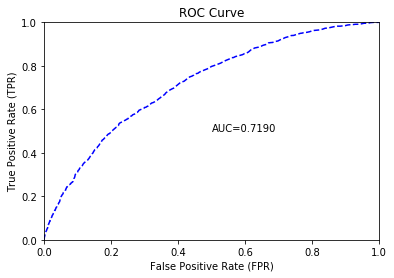


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.11957987420853115
RMSE: 0.34580323047729206
LogLoss: 0.39100916487798343
Null degrees of freedom: 9681
Residual degrees of freedom: 9678
Null deviance: 8292.432037983566
Residual deviance: 7571.501468697272
AIC: 7579.501468697272
AUC: 0.7190282166485633
pr_auc: 0.31858011098675587
Gini: 0.4380564332971266
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17073496828948442: 


,0,1,Error,Rate
0,6351.0,1849.0,0.2255,(1849.0/8200.0)
1,687.0,795.0,0.4636,(687.0/1482.0)
Total,7038.0,2644.0,0.2619,(2536.0/9682.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1707350,0.3853611,254.0
max f2,0.0992062,0.5279952,334.0
max f0point5,0.2657779,0.3526466,183.0
max accuracy,0.6641336,0.8483784,22.0
max precision,0.7969163,0.75,1.0
max recall,0.0591169,1.0,395.0
max specificity,0.8190913,0.9998780,0.0
max absolute_mcc,0.1707350,0.2512844,254.0
max min_per_class_accuracy,0.1332403,0.6530488,292.0
max mean_per_class_accuracy,0.1195953,0.6580759,307.0


Gains/Lift Table: Avg response rate: 15.31 %, avg score: 15.83 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100186,0.6186003,3.7043143,3.7043143,0.5670103,0.6857173,0.5670103,0.6857173,0.0371120,0.0371120,270.4314315,270.4314315
,2,0.0200372,0.5492220,2.7613979,3.2328561,0.4226804,0.5820001,0.4948454,0.6338587,0.0276653,0.0647773,176.1397944,223.2856129
,3,0.0300558,0.4965515,2.7613979,3.0757034,0.4226804,0.5209976,0.4707904,0.5962383,0.0276653,0.0924426,176.1397944,207.5703401
,4,0.0400744,0.4589289,2.3572909,2.8961003,0.3608247,0.4776276,0.4432990,0.5665856,0.0236167,0.1160594,135.7290928,189.6100282
,5,0.0500930,0.4305295,2.4246421,2.8018086,0.3711340,0.4445268,0.4288660,0.5421739,0.0242915,0.1403509,142.4642097,180.1808645
,6,0.1000826,0.3258105,2.1866865,2.4945650,0.3347107,0.3751560,0.3818369,0.4587511,0.1093117,0.2496626,118.6686519,149.4564983
,7,0.1500723,0.2566091,1.8897291,2.2930918,0.2892562,0.2882388,0.3509979,0.4019528,0.0944669,0.3441296,88.9729091,129.3091774
,8,0.2000620,0.2118105,1.6332659,2.1282205,0.25,0.2332703,0.3257615,0.3598039,0.0816464,0.4257760,63.3265857,112.8220456
,9,0.3000413,0.1586565,1.3565555,1.8710874,0.2076446,0.1819385,0.2864028,0.3005359,0.1356275,0.5614035,35.6555526,87.1087357
,10,0.4000207,0.1313002,0.9921078,1.6513992,0.1518595,0.1437256,0.2527756,0.2613434,0.0991903,0.6605938,-0.7892227,65.1399199


In [46]:
aml.leader.model_performance(test_data=test).plot()
aml.leader.model_performance(test_data=test)

Another convenient use of H2O Flow is to explore the various models built by AutoML.

# Step 10 (of 10). Stop H2O-3 cluster

In [47]:
h2o.cluster().shutdown()

H2O session _sid_ae8d closed.


# Bonus: H2O-3 documentation

* http://docs.h2o.ai